In [1]:
import pennylane as qml
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer
from pennylane import numpy as np
import math

import matplotlib.pyplot as plt

### Data Generation

In [2]:
np.random.seed(953)

In [3]:
# KY: adding alpha0 term for all codes //  ref check: [cos(x*a + a0)]

In [4]:
### Data of g function distribution
### Cos함수와 관련된 데이터를 만드는 함수

# cos(alpha_0*x_0 + alpha_1*x_1 + ... + alpha_n*x_n + alpha0)
def Cos(samples, alpha, xmin, xmax):
    """
    Generate datas we will use for the Model
    cos(alpha_0*x_0 + alpha_1*x_1 + ... + alpha_n*x_n)

    INPUT
    samples(int) : number of datas
    coefficients(array)\vec{\aplpha}] : coefficients for the x_i
    dim(int)[\vec{x}] : dimension of x data
    xmax : max value of each x_i
    xmin : min value of each x_i

    OUTPUT
    data sets(\vec{x}, cos(\vec{\alpha} \dot \vec{x}))
    """
    points= []
    results = []
    dim = len(alpha)

    def f(alpha, point):
        if len(alpha) != len(point):
            ValueError("dimension of alpha and x is not same")
    
        a = np.dot(alpha, point)
        return a

    # Mading sample points
    for i in range(samples):
        
        point = []
        for j in range(dim):
            x  = np.random.uniform(xmin[j], xmax[j])
            alpha0 = np.random.uniform(0, 5) ## cos(x*a + a0)
            point.append(x)


        result = np.cos(f(alpha, point)+alpha0)
        point.append(alpha0) ## cos(x*a + a0)

        points.append(point)
        results.append(result)

    return np.array(points, requires_grad = False), np.array(results, requires_grad = False)


# ------------------------------------------------------------------ #
alphas = [1, 2, 0.5]
xdim = len(alphas)
xmin = [0]*xdim
xmax=[3.5]*xdim
Xdata, ydata = Cos(10, alphas, xmin , xmax)
print(Xdata.shape)
print(ydata)
print(Xdata[:,0])

(10, 4)
[ 0.6211361  -0.89238065  0.98791774 -0.63237491 -0.38706306  0.41739335
  0.82645994  0.16560055 -0.15613308 -0.19149881]
[3.24982972 0.98203814 2.57163617 1.88022897 3.44652547 2.85056918
 0.39430486 0.34089409 3.21435332 3.31554153]


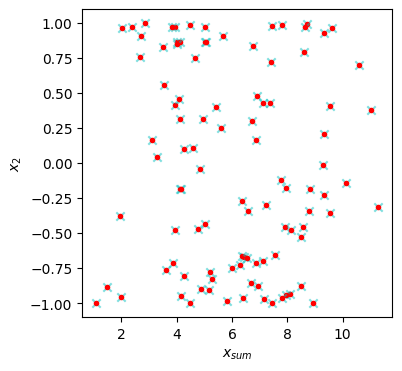

In [5]:
def plot_data(x, alpha, y, fig = None, ax = None):
    
    # Graph figure
    if fig == None :
        fig, ax = plt.subplots(1,1,figsize = (5, 5))
    
    def f(alpha, point):
        if len(alpha) != len(point):
            ValueError("dimension of alpha and x is not same")
    
        a = np.dot(alpha, point)
        return a
    
    for i in range(len(x)):
        x1 = f(alpha, x[i,:len(alpha)])
        x2 = y[i]
        s = np.linspace(0, 10)
        ax.scatter(x1, x2, alpha=0.5, color = 'c', marker='x')
        ax.scatter(x1, np.cos(x1+x[i,len(alpha)]), color = 'r', marker='.')
        ax.set_xlabel("$x_{sum}$")
        ax.set_ylabel("$x_2$")

# ------------------------------------------------------------------ #

fig, ax = plt.subplots(figsize=(4, 4))
Xdata, ydata = Cos(100, [1, 2, 1/2], xmin=xmin, xmax = xmax)
# plot_data(Xdata[:,:len(xmin)], [1, 2, 1/2], ydata, fig, ax)  ## cos(x*a + a0)
plot_data(Xdata, [1, 2, 1/2], ydata, fig, ax)  ## cos(x*a + a0)

### Variational Quantum Circuit Model

/home/kban/.local/lib/python3.8/site-packages/pennylane_lightning/lightning_qubit/lightning_qubit.py:822: UserWarning: Pre-compiled binaries for lightning.qubit are not available. Falling back to using the Python-based default.qubit implementation. To manually compile from source, follow the instructions at https://pennylane-lightning.readthedocs.io/en/latest/installation.html.
  warn(


[0.55417597 0.05163941 0.38756273 0.15943217 0.5194893  0.26117749
 0.43248552 0.82554736 0.97847771 0.38046766 0.46523981 0.85161599
 0.54566301 0.65362471 0.73837289 0.59675326 0.42056892 0.25487891
 0.91313061 0.41507411 0.14011859 0.29635517 0.3683617  0.39076343
 0.90303058 0.33683194 0.38533447 0.21847502 0.69427226 0.41039608
 0.26915202 0.68305488 0.2530709  0.59733481 0.91658611 0.08911516
 0.58938909 0.95478533 0.30258465 0.0336776 ]
4
40
------------------------------------------------------------------
0.11229591171623124
------------------------------------------------------------------


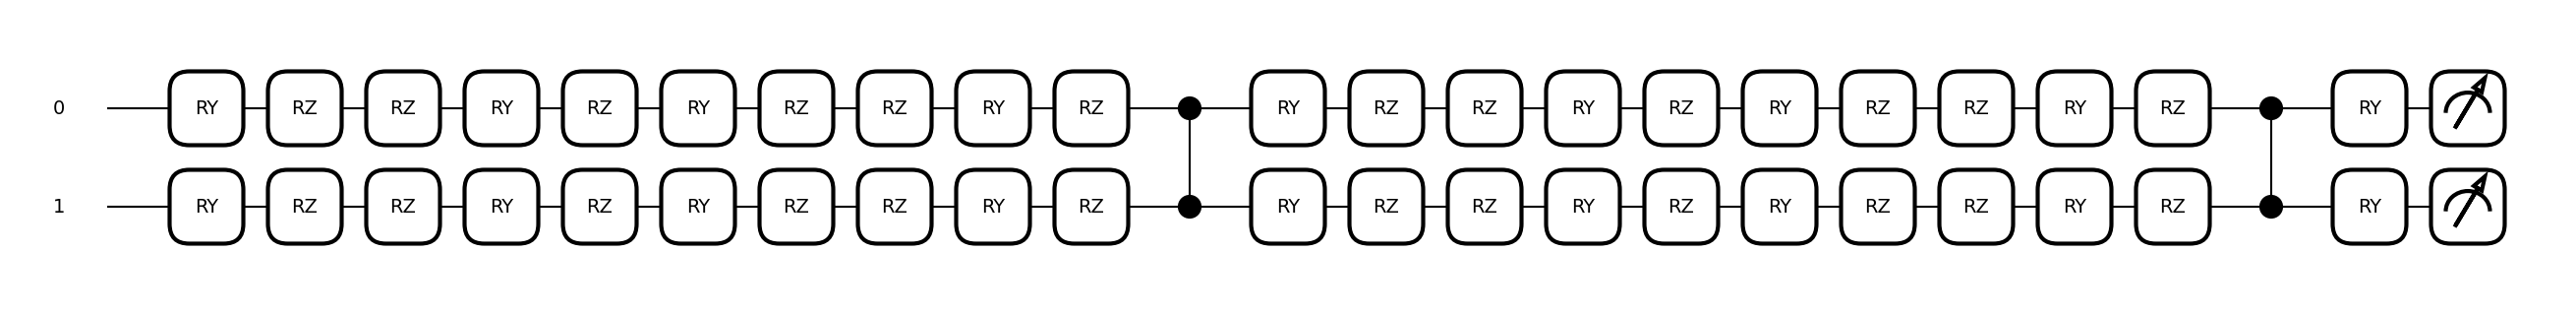

In [6]:
dev = qml.device("lightning.qubit", wires = 10)

@qml.qnode(dev)
def VQC_Model(thetas, phis, x, num_layers):
    """
    Variational Quantum Circuit model for Multi Variable Integration

    INPUT
    params : parameters for the circuit we will train them
    phis : array of parameters applied to the last RY gate
    x(Xdata[i]) : data point we have to upload
    num_layers : layers for the circuit

    OUTPUT
    Expectation value with PauliZ measure
    """
    
    dim = len(x)
    num_qubits = math.ceil(dim / 2)
    idx = 0

    params = list(thetas).copy()
    
    for _ in range(num_layers):
        for i in range(dim):
            qubit = i // 2
            qml.RY(params[idx], wires = qubit)
            qml.RZ(params[idx+1]*x[i], wires = qubit, id = f'x{i}') # Re-uploading data here
            qml.RZ(params[idx+2], wires = qubit)
            qml.RY(params[idx+3], wires = qubit)
            qml.RZ(params[idx+4], wires = qubit)
            idx += 5

        if num_qubits > 1:
            for q in range(0,num_qubits-1,1):
                qml.CZ([q, q+1])
            if num_qubits > 2:
                qml.CZ([num_qubits-1, 0])

    if num_qubits > 1:
        for i in range(num_qubits):
            qml.RY(phis[i], wires=i, id = f"phi{i}")
    
    obs = qml.PauliZ(0)
    for i in range(num_qubits-1):
         obs = obs @ qml.PauliZ(i+1)

    return qml.expval(obs)

# ------------------------------------------------------------------ #
Xdata, ydata = Cos(10, alphas, xmin, xmax)
x = Xdata[0]
dim = len(x)
num_layers = 2
num_qubits = math.ceil(len(x) / 2)

thetas = np.random.uniform(size = dim*num_layers*5,requires_grad = True)
phis = np.random.uniform(size = num_qubits, requires_grad =True)



print(thetas)
print(len(x))
print(len(thetas))
print('------------------------------------------------------------------')
print(VQC_Model(thetas, phis, x, num_layers))
print('------------------------------------------------------------------')
fig, ax = qml.draw_mpl(VQC_Model)(thetas, phis, x, num_layers)


### Cost function

In [7]:
def cost_function(thetas, phis, Xdata, num_layers, y):
    loss = 0.0

    for i in range(len(Xdata)):
        prediction = VQC_Model(thetas, phis, Xdata[i], num_layers)
        loss += (prediction - y[i])**2

    return loss / len(Xdata)

# ------------------------------------------------------------------ #

#Xdata, ydata = Cos(100, [1, 2, 1/2], 3, xmax=[np.pi, np.pi, np.pi], xmin = [0, 0, 0])
#x = Xdata[:20]
#dim = len(x)
#num_layers = 2
#num_qubits = math.ceil(len(x) / 2)

#thetas = np.random.uniform(size = dim*num_layers*5,requires_grad = True)
#phis = np.random.uniform(size = num_qubits, requires_grad =True)

#cost_function(thetas, phis, x, num_layers, ydata)


### Model Running

In [8]:
def model_running(thetas, phis, x, num_layers):
    """
    Model running with given set of data.

    INPUT


    Returns
    Predicted labels for given data, Expectation value of the circuit
    """
    
    exepctation_values = []

    for i in range(len(x)):
        expval = VQC_Model(thetas, phis, x[i], num_layers)
        exepctation_values.append(expval)
        
    return np.array(exepctation_values)

In [9]:
def accuracy(ypred, ydata):

    ratio = []
    score = 0
    for i in range(len(ydata)):
        acc = ypred[i] / ydata[i] - 1
        if np.abs(acc) < 0.2:
            score += 1
        ratio.append(ypred[i] / ydata[i])

    return ratio, score/len(ydata)

In [10]:
def iterate_minibatches(inputs, targets, batch_size):
    """
    A generator for batches of the input data
    
    INPUT
    inputs : input data
    targets : targets
    batch_size : size of the batch, the number of datas in one batch

    Returns
    one batch of input data of length `batch_size`, one batch of targets of length `batch_size`
    """
    for start_idx in range(0, inputs.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield inputs[idxs], targets[idxs]

-------------

In [11]:
### Preparing datas
train_data, train_target = Cos(250, alphas, xmin, xmax)
test_data, test_target = Cos(750, alphas, xmin, xmax)

# for making cos(x*a + a0)
x = train_data[0]
dim = len(x)

# Trainnig option settings
num_layers = 2
epochs = 100
batch_size = 50
lr = 0.03

# Using the Optimizer
opt = AdamOptimizer(lr)                 ### Adam Optimizer
#opt = GradientDescentOptimizer(lr)      ### GradientDescent based on Parmaeter Shift Rule

# Initializing random parameters for the circuit
thetas = np.random.uniform(size=dim*num_layers*5, requires_grad=True)
phis = np.random.uniform(size = num_qubits, requires_grad =True)

### Evaluating the qNN
# Running the model with test data
pred_train = model_running(thetas, phis, train_data, num_layers)
ratio_train, score_train = accuracy(pred_train, train_target)

# Running the model with the test data
pred_test = model_running(thetas, phis, test_data, num_layers)
ratio_test, score_test = accuracy(pred_test, test_target)

# Saving predictions with random weights for comparison 
initial_predictions = pred_test

loss = cost_function(thetas, phis, test_data, num_layers, test_target)

loss_list = [loss]
accuracy_train_list = [score_train]
accuracy_test_list = [score_test]

print(
    "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
        0, loss.item(), score_train, score_test
    )
)

for it in range(epochs):
    for Xbatch, ybatch in iterate_minibatches(train_data, train_target, batch_size=batch_size):
        thetas, phis, _, _, _ = opt.step(cost_function, thetas, phis, Xbatch, num_layers, ybatch)

    pred_train = model_running(thetas, phis, train_data, num_layers)
    ratio_train, score_train = accuracy(pred_train, train_target)
    loss = cost_function(thetas, phis, train_data, num_layers, train_target)

    pred_test = model_running(thetas, phis, test_data, num_layers)
    ratio_test, score_test = accuracy(pred_test, test_target)
    res = [it + 1, loss.item(), score_train, score_test]
    print(
        "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(
            *res
        )
    )

    loss_list.append(loss)
    accuracy_train_list.append(score_train)
    accuracy_test_list.append(score_test)


Epoch:  0 | Cost: 0.810147 | Train accuracy: 0.124000 | Test Accuracy: 0.124000
Epoch:  1 | Loss: 0.522414 | Train accuracy: 0.044000 | Test accuracy: 0.044000
Epoch:  2 | Loss: 0.404170 | Train accuracy: 0.084000 | Test accuracy: 0.057333
Epoch:  3 | Loss: 0.320968 | Train accuracy: 0.108000 | Test accuracy: 0.058667
Epoch:  4 | Loss: 0.207045 | Train accuracy: 0.120000 | Test accuracy: 0.132000
Epoch:  5 | Loss: 0.101669 | Train accuracy: 0.208000 | Test accuracy: 0.225333
Epoch:  6 | Loss: 0.048045 | Train accuracy: 0.352000 | Test accuracy: 0.364000
Epoch:  7 | Loss: 0.029788 | Train accuracy: 0.488000 | Test accuracy: 0.485333
Epoch:  8 | Loss: 0.021478 | Train accuracy: 0.612000 | Test accuracy: 0.566667
Epoch:  9 | Loss: 0.014701 | Train accuracy: 0.672000 | Test accuracy: 0.644000
Epoch: 10 | Loss: 0.009871 | Train accuracy: 0.720000 | Test accuracy: 0.728000
Epoch: 11 | Loss: 0.006648 | Train accuracy: 0.780000 | Test accuracy: 0.773333
Epoch: 12 | Loss: 0.004317 | Train accur

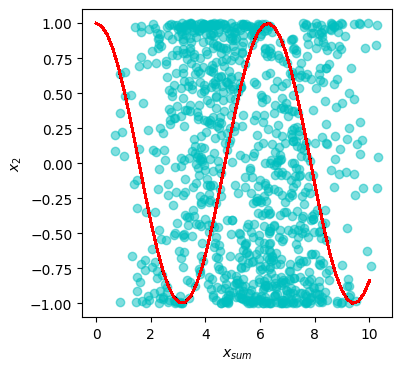

In [12]:
def plot_data(x, alpha, y, fig = None, ax = None):
    
    # Graph figure
    if fig == None :
        fig, ax = plt.subplots(1,1,figsize = (5, 5))
    
    def f(alpha, point):
        if len(alpha) != len(point):
            ValueError("dimension of alpha and x is not same")
    
        a = np.dot(alpha, point)
        return a
    
    for i in range(len(x)):
        x1 = f(alpha, x[i])
        x2 = y[i]
        s = np.linspace(0, 10)
        ax.scatter(x1, x2, alpha=0.5, color = 'c')
        ax.plot(s, np.cos(s), color = 'r')
        ax.set_xlabel("$x_{sum}$")
        ax.set_ylabel("$x_2$")

# ------------------------------------------------------------------ #

fig, ax = plt.subplots(figsize=(4, 4))
Xdata, ydata = Cos(1000, [1, 2, 1/2], xmin=[0, 0, 0], xmax = [np.pi, np.pi, np.pi])
plot_data(Xdata[:,:len(xmin)], [1, 2, 1/2], ydata, fig, ax) # for making cos(x*a + a0)

Cost: 0.000094 | Train accuracy 0.932000 | Test Accuracy : 0.961333
Learned weights
thetas = [ 0.52327772  0.01528416  0.31295314  0.58958286  0.33144026  0.61326899
  0.83185823  0.99607307  0.11144585  0.69943358  1.26179946  0.00969067
  0.55267504  0.82451834  0.61650288  0.52232931  0.01320075  0.62274458
  0.81948895  0.77289002  0.03318919  0.99213915 -0.01644903  0.05534437
 -0.17821618 -0.0684008   1.17219296  0.46571724 -0.06926692 -0.01092449
  1.47575829  0.5040703   0.00565947 -0.19097572 -0.01906869  0.27739264
  0.99987257  0.72578224  0.6813972   0.00518333]
phis = [1.56405187 1.56119079]


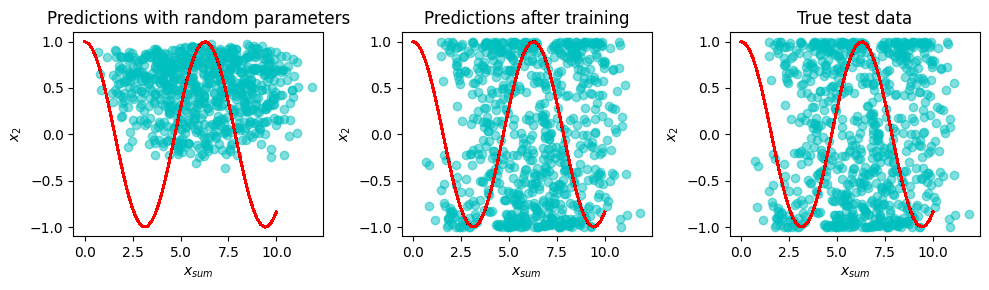

In [13]:
print(
    "Cost: {:3f} | Train accuracy {:3f} | Test Accuracy : {:3f}".format(
        loss, score_train, score_test
    )
)

print("Learned weights")
print("thetas = {}".format(thetas))
print("phis = {}".format(phis))

fig, axes = plt.subplots(1, 3, figsize=(10, 3))
plot_data(test_data[:,:len(xmin)], [1, 2, 1/2], initial_predictions, fig, axes[0])
plot_data(test_data[:,:len(xmin)], alphas, pred_test, fig, axes[1])
plot_data(test_data[:,:len(xmin)], alphas, test_target, fig, axes[2])

axes[0].set_title("Predictions with random parameters")
axes[1].set_title("Predictions after training")
axes[2].set_title("True test data")
plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


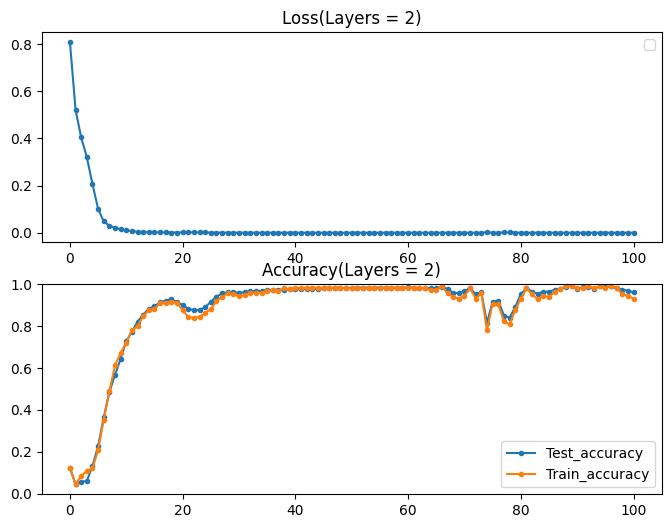

In [14]:
fig, axes = plt.subplots(2, 1, figsize=(8, 6))

axes[0].plot(loss_list,'.-')
axes[1].plot(accuracy_test_list,'.-', label = 'Test_accuracy')
axes[1].plot(accuracy_train_list,'.-', label = 'Train_accuracy')
axes[0].legend()
axes[1].legend()
axes[1].set_ylim(top = 1.0)
axes[0].set_title(f"Loss(Layers = {num_layers})")
axes[1].set_title(f"Accuracy(Layers = {num_layers})")
plt.show()

### Results for $g_{est}$

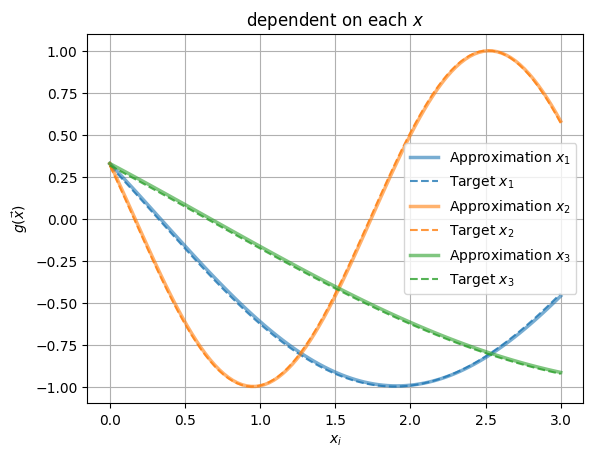

In [22]:
xlin = np.linspace(0,3,100)
arr = np.zeros(100)

num_layers = 2
alphas = [1, 2, 1/2]
dim = len(alphas)

alpha0 = [1.25]*100

xlin_data1 = np.stack((xlin, arr, arr, alpha0), axis=1)
xlin_data2 = np.stack((arr, xlin, arr, alpha0), axis=1)
xlin_data3 = np.stack((arr, arr, xlin, alpha0), axis=1)
integral = 0
xlin_data = np.stack((xlin_data1, xlin_data2, xlin_data3), axis=0)
for i in range(dim):
        ypred = model_running(thetas, phis, xlin_data[i], num_layers)
        ytrue = np.cos(alphas[i]*xlin+alpha0)

        color = plt.rcParams["axes.prop_cycle"].by_key()["color"][i]

        plt.plot(xlin, 
                ypred,
                label=f"Approximation $x_{i+1}$",
                linewidth = 2.5,
                alpha = 0.6,
                ls = "-",
                color = color)

        plt.plot(
                xlin,
                ytrue,
                label=f"Target $x_{i+1}$",
                linewidth=1.5,
                alpha=0.8,
                ls="--",
                color=color)
        
plt.grid(True)
plt.title(f"dependent on each $x$")
plt.xlabel(f"$x_i$")
plt.ylabel(r"$g({\vec{x}})$")
plt.legend()
plt.show()

### Results for $I(\cdots,x_{i-1},x_{i+1},\cdots)$

#### 변수 $x_2$와 $x_3$에 대한 적분을 수행하고 그 결과를 $ x_1 $값의 함수로 표현하고 싶다면, 우리는 두 변수에 대한 이중적분을 계산

#### 함수 $ g_{est}(x_1, x_2, x_3, \alpha_0)$에 대해 $ \alpha_0 = 1.25 $로 고정하고, $ x_2 $와 $ x_3 $에 대해 0부터 3까지의 적분을 리만 적분으로 근사

1. **이중적분 설정**:
$ I(x_1) = \int_{0}^{3} \int_{0}^{3}  g_{est}(x_1, x_2, x_3, \alpha_0) \, dx_2 \, dx_3 $

2. **구간 나누기**:
두 변수 $ x_2 $와 $ x_3 $에 대해 구간 [0, 3]을 $ N $개의 작은 구간으로 나눕니다. 각 변수에 대한 구간의 너비는 $ \Delta x = \frac{3 - 0}{N} $로 동일

3. **함수의 값 계산**:
이중 합을 사용하여 리만 합을 계산하기 위해, 각 구간에 대한 대표값 $ x_{2i} $와 $ x_{3j} $에서 함수의 값을 계산

4. **이중 리만 합 계산**:
각 대표값에서 함수의 값을 곱한 후, 모든 $ x_2 $와 $ x_3 $의 구간에 대해 이를 더하여 이중 리만 합을 계산

$ I_{\text{Riemann}}(x_1) = \sum_{i=1}^{N} \sum_{j=1}^{N}  g_{est}(x_1, x_2, x_3, \alpha_0) \Delta x^2 $

5. **적분값 계산**:
리만 합을 계산한 후, $ N $을 충분히 크게 취하여 근사적분값 $ I_{\text{Riemann}}(x_1) $이 실제 이중적분 값에 근사됨

6. **결과 해석**:
$ x_1 $에 대해 $ I_{\text{Riemann}}(x_1) $를 계산하면, 이는 $ x_1 $의 함수로서의 이중적분 결과를 얻을 수 있음

In [33]:
def ratio(pred, target, eps=1e-3):
    return np.abs(pred-target) #/target
    # tts = np.where(np.abs(target) > eps, target, np.sign(target) * eps)
    # ccs = np.where(np.abs(pred) > eps, pred, np.sign(pred) * eps)
    # return np.abs(tts / ccs)

In [ ]:
from multiprocessing import Pool
import time

# Define the integrand function
def integrand(thetas, phis, x, num_layers):
    return model_running(thetas, phis, x, num_layers)

# Set the value for alpha0
alpha0 = 1.25

# Set the bounds of the integration for x2 and x3
lower_bound = 0
upper_bound = 3


# Choose the number of points for the Riemann sum (more points -> better approximation)
N = 501  # This is an example; in practice, you might need a larger number for a good approximation
delta_x = (upper_bound - lower_bound) / (N-1)
xlin = np.linspace(0,3,N-1)


# Assuming model_running, thetas, phis, num_layers, and xlin are defined elsewhere

def compute_integral_for_x1(x1_data):
    x1, thetas, phis, alpha0, lower_bound, upper_bound, delta_x, N, num_layers = x1_data
    I_riemann_x1 = 0
    for i in range(N):
        for j in range(N):
            x2 = lower_bound + i * delta_x
            x3 = lower_bound + j * delta_x
            int_data = np.array([[x1, x2, x3, alpha0]], requires_grad=False)
            I_riemann_x1 += integrand(thetas, phis, int_data, num_layers) * delta_x ** (xdim-1)
    return I_riemann_x1.item()

def integrand_parallel(thetas, phis, alpha0, lower_bound, upper_bound, delta_x, N, num_layers, xlin):
    start_time = time.time()  # 시간 측정 시작
    # Prepare data for each x1 to be used in parallel processing
    tasks = [(x1, thetas, phis, alpha0, lower_bound, upper_bound, delta_x, N, num_layers) for x1 in xlin]

    # Use all available CPUs
    with Pool() as pool:
        integral_results_ = pool.map(compute_integral_for_x1, tasks)
    end_time = time.time()  # 시간 측정 종료
    print(f"Parallel processing took {end_time - start_time} seconds.")    
    return integral_results_

# Use the parallel function
integral_results_ = integrand_parallel(thetas, phis, alpha0, lower_bound, upper_bound, delta_x, N, num_layers, xlin)


Text(0.5, 0, '$x_1$')

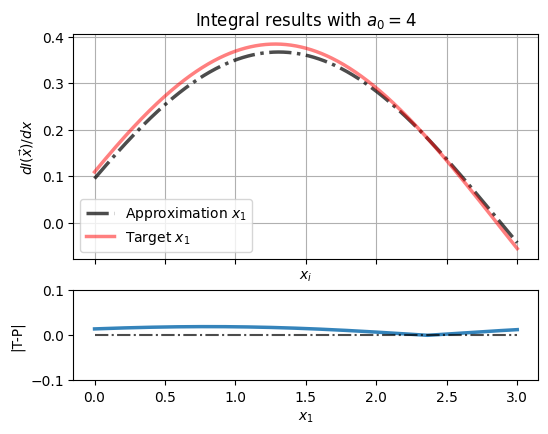

In [38]:
# g integrated over x2 and x3 from 0 to 3
# -1.0*cos(x1 + 1.25) + 1.0*cos(x1 + 2.75) + 1.0*cos(x1 + 7.25) - 1.0*cos(x1 + 8.75)
# To-do: numerical integration results, maybe we can use integrand with true g(x,a)
ytrue = -1.0*np.cos(xlin + 1.25) + 1.0*np.cos(xlin + 2.75) + 1.0*np.cos(xlin + 7.25) - 1.0*np.cos(xlin + 8.75)

i = 1 # x_1

fig, (ax1, ax2) = plt.subplots(
    2, 1, sharex=True, figsize=(6, 6 * 6 / 8), gridspec_kw={"height_ratios": [5, 2]}
)

ax1.plot(xlin, 
        integral_results_,
        label=f"Approximation $x_{i}$",
        linewidth = 2.5,  ls="-.", color="black", alpha=0.7)

ax1.plot(
        xlin,
        ytrue,
        label=f"Target $x_{i}$",
        linewidth=2.5,
        alpha=0.5,
        color='red')
        
ax1.grid(True)
ax1.set_title(f"Integral results with $a_0 = {alpha0}$")
ax1.set_xlabel(f"$x_i$")
ax1.set_ylabel(r"$dI({\vec{x}})/dx$")
ax1.legend()


rr = ratio(integral_results_, ytrue)

# r1 = ratio(c_p, target_vals)
# r2 = ratio(c_m, target_vals)
# rp = np.maximum(r1, r2)
# rm = np.minimum(r1, r2)
# fig.legend(bbox_to_anchor=(0.85, 0.88), framealpha=1)

ax2.plot(xlin, rr, alpha=0.9, lw=2.5)
ax2.hlines(0, 0, 3, color="black", alpha=0.7, ls="-.", lw=1.5)
ax2.set_ylim(-0.1,0.1)
ax2.set_ylabel("|T-P|")
ax2.grid(False)
ax2.set_xlabel(rf"$x_{i}$")

In [ ]:
from multiprocessing import Pool
import time

# Define the integrand function
def integrand(thetas, phis, x, num_layers):
    return model_running(thetas, phis, x, num_layers)

# Set the value for alpha0
alpha0 = 4

# Set the bounds of the integration for x2 and x3
lower_bound = 0
upper_bound = 3


# Choose the number of points for the Riemann sum (more points -> better approximation)
N = 501  # This is an example; in practice, you might need a larger number for a good approximation
delta_x = (upper_bound - lower_bound) / (N-1)
xlin = np.linspace(0,3,N-1)


# Assuming model_running, thetas, phis, num_layers, and xlin are defined elsewhere

def compute_integral_for_x1(x1_data):
    x1, thetas, phis, alpha0, lower_bound, upper_bound, delta_x, N, num_layers = x1_data
    I_riemann_x1 = 0
    for i in range(N):
        for j in range(N):
            x2 = lower_bound + i * delta_x
            x3 = lower_bound + j * delta_x
            int_data = np.array([[x1, x2, x3, alpha0]], requires_grad=False)
            I_riemann_x1 += integrand(thetas, phis, int_data, num_layers) * delta_x ** (xdim-1)
    return I_riemann_x1.item()

def integrand_parallel(thetas, phis, alpha0, lower_bound, upper_bound, delta_x, N, num_layers, xlin):
    start_time = time.time()  # 시간 측정 시작
    # Prepare data for each x1 to be used in parallel processing
    tasks = [(x1, thetas, phis, alpha0, lower_bound, upper_bound, delta_x, N, num_layers) for x1 in xlin]

    # Use all available CPUs
    with Pool() as pool:
        integral_results_ = pool.map(compute_integral_for_x1, tasks)
    end_time = time.time()  # 시간 측정 종료
    print(f"Parallel processing took {end_time - start_time} seconds.")    
    return integral_results_

# Use the parallel function
integral_results_4 = integrand_parallel(thetas, phis, alpha0, lower_bound, upper_bound, delta_x, N, num_layers, xlin)


Text(0.5, 0, '$x_1$')

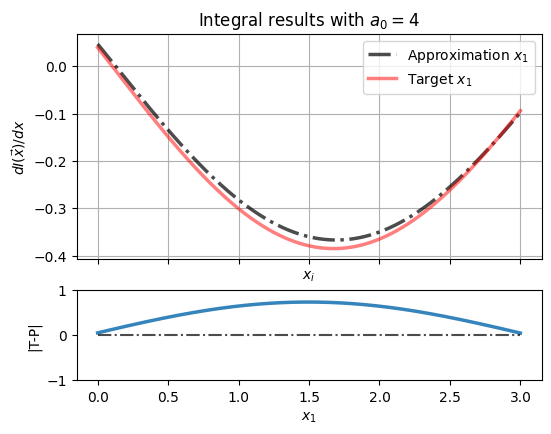

In [39]:
# g integrated over x2 and x3 from 0 to 3
# -1.0*cos(x1 + 1.25) + 1.0*cos(x1 + 2.75) + 1.0*cos(x1 + 7.25) - 1.0*cos(x1 + 8.75)
# To-do: numerical integration results, maybe we can use integrand with true g(x,a)
ytrue = -1.0*np.cos(xlin + 4) + 1.0*np.cos(xlin + 5.5) + 1.0*np.cos(xlin + 10) - 1.0*np.cos(xlin + 11.5)

i = 1 # x_1

fig, (ax1, ax2) = plt.subplots(
    2, 1, sharex=True, figsize=(6, 6 * 6 / 8), gridspec_kw={"height_ratios": [5, 2]}
)

ax1.plot(xlin, 
        integral_results_4,
        label=f"Approximation $x_{i}$",
        linewidth = 2.5,  ls="-.", color="black", alpha=0.7)

ax1.plot(
        xlin,
        ytrue,
        label=f"Target $x_{i}$",
        linewidth=2.5,
        alpha=0.5,
        color='red')
        
ax1.grid(True)
ax1.set_title(f"Integral results with $a_0 = {alpha0}$")
ax1.set_xlabel(f"$x_i$")
ax1.set_ylabel(r"$dI({\vec{x}})/dx$")
ax1.legend()


rr = ratio(integral_results_, ytrue)

# r1 = ratio(c_p, target_vals)
# r2 = ratio(c_m, target_vals)
# rp = np.maximum(r1, r2)
# rm = np.minimum(r1, r2)
# fig.legend(bbox_to_anchor=(0.85, 0.88), framealpha=1)

ax2.plot(xlin, rr, alpha=0.9, lw=2.5)
ax2.hlines(0, 0, 3, color="black", alpha=0.7, ls="-.", lw=1.5)
ax2.set_ylim(-1,1)
ax2.set_ylabel("|T-P|")
ax2.grid(False)
ax2.set_xlabel(rf"$x_{i}$")